In [1]:
import numpy as np
import os
import tempfile
import keras
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import History 
from keras.models import load_model
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.layers import Concatenate
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import random
from termcolor import colored
from IPython.display import clear_output
from load_5hot import load
import datetime


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
[X_train,Y_train,X_test,Y_test,X_val,Y_val] = load("blast_tab_1hit.out")

m = X_train.shape[0]
print("There are " + str(m) + " training examples")
print("There are " + str(X_test.shape[0]) + " testing examples")
print("There are " + str(X_train.shape[1]) + " classes: A, C, G, T, -")
max_length = max(X_train.shape[2],X_test.shape[2])
print("The longest sequence is " + str(max_length) + " nucleotides long")
print("X_train shape is:")
print(X_train.shape)

print('Permuting...')
np.random.seed(0)
rand_perm = np.random.rand(m).argsort()
np.take(X_train,rand_perm,axis=0,out=X_train)
print("finished X")
np.take(Y_train,rand_perm,axis=0,out=Y_train)
print("finished Y")

#Change dimensions so that we have examples x seqlen x onehot
X_train = np.squeeze(np.swapaxes(X_train, 1, 2))
Y_train = np.squeeze(np.swapaxes(Y_train, 1, 2))
X_val = np.squeeze(np.swapaxes(X_val, 1, 2))
Y_val = np.squeeze(np.swapaxes(Y_val, 1, 2))
X_test = np.squeeze(np.swapaxes(X_test, 1, 2))
Y_test = np.squeeze(np.swapaxes(Y_test, 1, 2))

# Visualize data sets to ensure they appear as anticipated
sample = 0
print('Training sample 0:')
print(X_train[sample,0:22, :])
print(Y_train[sample,0:22, :])
print('Validation sample 0:')
print(X_val[sample,0:22, :])
print(Y_val[sample,0:22, :])
print('Testing sample 0:')
print(X_test[sample,0:22, :])
print(Y_test[sample,0:22, :])

Loading Data...
101886 sequences were uploaded

Maximum sequence length in is 308
Maximum sequence length out is 308

Converting to one-hot...
Done
Converting to one-hot...
Done
Converting to one-hot...
Done
There are 77510 training examples
There are 12107 testing examples
There are 5 classes: A, C, G, T, -
The longest sequence is 308 nucleotides long
X_train shape is:
(77510, 5, 308, 1)
Permuting...
finished X
finished Y
Training sample 0:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0.

In [3]:
one_hot_input = {'A': 0, 'C': 1, 'G': 2, 'T': 3, '-': 4}
num_encoder_tokens = len(one_hot_input)
num_decoder_tokens = len(one_hot_input)
latent_dim = 100

encoder_inputs = Input(shape=(None, num_encoder_tokens))
e_lstm_1 = Bidirectional(LSTM(latent_dim, return_sequences = True))(encoder_inputs)
e_dropout = Dropout(0.5)(e_lstm_1)
e_lstm_2 = Bidirectional(LSTM(latent_dim, return_sequences = True))(e_dropout)
#e_lstm_3 = Bidirectional(LSTM(latent_dim, return_sequences = True))

output = TimeDistributed(Dense(num_decoder_tokens, activation = "softmax"))(e_lstm_2)
#noise_class = Dense(1, activation = "tanh")(Concatenate()([h2, c2]))
#noise_class = Activation("tanh")(noise_class)
#print(noise_class)



In [ ]:
#Train by classification of noisy/non-noisy

#model = Model(encoder_inputs, noise_class)

#model.load_weights("seqWeights/LSTM-comboseqs-dropout0.5-manytomany-01-0.82.hdf5")
#adam = keras.optimizers.Adam(lr = .001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#model.compile(optimizer= adam, loss='binary_crossentropy', metrics = ['accuracy'])

#history = History()
#filepath="seqWeights/LSTM-test-{epoch:02d}-{val_acc:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#numExamples = 1000
#batch_size = 100
#epochs = 50
#output_seqs = decoder_input_data[0:numExamples, :, :]
#y = output_seqs.reshape(numExamples, output_seqs.shape[1], 1)
#model.fit(encoder_input_data[0:numExamples, :, :],
#          np.array(labels)[0:numExamples],
#          batch_size=batch_size,
#          epochs=epochs,
#          validation_split=0.2, verbose = 1,
#         callbacks = [history, checkpoint])


In [6]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []
        
        #ts = time.time()
        #stamp = datetime.datetime.fromtimestamp(ts).strftime('%H:%M:%S')
        
        #self.losses_file = open('log_loss.txt', 'w')
        #self.losses_file.truncate()
        #self.losses_file.close()
        #self.val_loss_file = open('log_val_loss.txt', 'w')
        #self.val_loss_file.truncate()
        #self.val_loss_file.close()
        #self.val_acc_file = open('log_val_acc.txt', 'w')
        #self.val_acc_file.truncate()
        #self.val_acc_file.close()

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        #plt.plot(self.x, self.val_acc, label = "val_acc")
        plt.legend()
        plt.show();
        

        
        self.losses_file = open('log_loss' + datetime.date.time() + '.txt', 'a')
        self.losses_file.write(str(logs.get('loss')) + ",")
        self.losses_file.close()
        
        self.val_loss_file = open('log_val_loss' + datetime.date.time() + '.txt', 'a')
        self.val_loss_file.write(str(logs.get('val_loss')) + ",")
        self.val_loss_file.close()
        
        self.val_acc_file = open('log_val_acc' + datetime.date.time() + '.txt', 'a')
        self.val_acc_file.write(str(logs.get('val_acc')) + ",")
        self.val_acc_file.close()
        
plot_losses = PlotLosses()

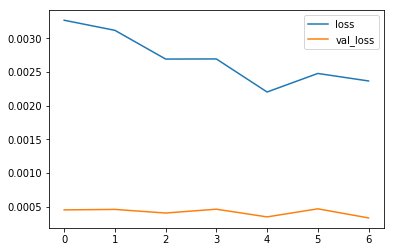

Epoch 8/30
73600/77510 [===========================>..] - ETA: 4:03 - loss: 0.0022 - acc: 0.8876

KeyboardInterrupt: 

In [22]:
#Train by sequence correctness
model = Model(encoder_inputs, output)

#model.load_weights("seqWeights/LSTM-test-comboseqs-dropout0.5-manytomany-11-0.83.hdf5")
adam = keras.optimizers.Adam(lr = .001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.95, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])

history = History()
filepath="seqWeights/LSTM-2-comboseqs-dropout0.5-manytomany-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only= False, mode='max')

#numExamples = 70000
batch_size = 100
epochs = 30
#output_seqs = decoder_input_data[0:numExamples, :, :]
#y = output_seqs.reshape(numExamples, output_seqs.shape[1], 1)
model.fit(x = X_train, y = Y_train,
          validation_data = (X_val, Y_val),
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          callbacks = [history, checkpoint, plot_losses])


In [4]:
os.listdir("seqWeights/final/")

['LSTM-2-comboseqs-dropout0.5-manytomany-01-0.84.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-02-0.84.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-03-0.83.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-04-0.83.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-05-0.90.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-06-0.89.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-07-0.94.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-08-0.94.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-09-0.93.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-10-0.90.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-11-0.89.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-12-0.89.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-13-0.89.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-14-0.90.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-15-0.88.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-16-0.89.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-17-0.88.hdf5',
 'LSTM-2-comboseqs-dropout0.5-manytomany-18-0.86

In [4]:

def getPredicted(weightFile, X_data):
        #calculate probabilities from model for test data
        model.load_weights("seqWeights/final/" + weightFile)
        probs = np.array(model.predict(X_data))
        #print(probs.shape)
        
        #convert from soft max to hard max
        max_vals = np.max(probs, axis = -1, keepdims = True)
        hard_max = np.zeros(probs.shape)
        hard_max[probs == max_vals] = 1
        print(hard_max.shape)
        
        return(hard_max)

In [6]:
import os
from accuracy_calculations import calcError
model = Model(encoder_inputs, output)
pred_errs_base_train = []
pred_errs_base_val = []
pred_errs_base_test = []

pred_errs_seq_train = []
pred_errs_seq_val = []
pred_errs_seq_test = []
for file in os.listdir("seqWeights/final/"):
    print(file)
    if file.endswith(".hdf5"):
      
        err_test = calcError(y_predicted = getPredicted(file, X_test), 
                                        y_true = Y_test, X_data = X_test, verbose = False)
        err_val = calcError(y_predicted = getPredicted(file, X_val), 
                                        y_true = Y_val, X_data = X_val, verbose = False)
        err_train = calcError(y_predicted = getPredicted(file, X_train), 
                                        y_true = Y_train, X_data = X_train, verbose = False)
        pred_errs_base_test.append(err_test['perBase'])
        pred_errs_seq_test.append(err_test['perSeq'])
        
        pred_errs_base_val.append(err_val['perBase'])
        pred_errs_seq_val.append(err_val['perSeq'])
        
        pred_errs_base_train.append(err_train['perBase'])
        pred_errs_seq_train.append(err_train['perSeq'])


LSTM-2-comboseqs-dropout0.5-manytomany-01-0.84.hdf5
(12107, 308, 5)
(12107, 308, 5)
(12269, 308, 5)
(12269, 308, 5)
(77510, 308, 5)
(77510, 308, 5)
LSTM-2-comboseqs-dropout0.5-manytomany-02-0.84.hdf5
(12107, 308, 5)
(12107, 308, 5)
(12269, 308, 5)
(12269, 308, 5)
(77510, 308, 5)
(77510, 308, 5)
LSTM-2-comboseqs-dropout0.5-manytomany-03-0.83.hdf5
(12107, 308, 5)
(12107, 308, 5)
(12269, 308, 5)
(12269, 308, 5)
(77510, 308, 5)
(77510, 308, 5)
LSTM-2-comboseqs-dropout0.5-manytomany-04-0.83.hdf5
(12107, 308, 5)
(12107, 308, 5)
(12269, 308, 5)
(12269, 308, 5)
(77510, 308, 5)
(77510, 308, 5)
LSTM-2-comboseqs-dropout0.5-manytomany-05-0.90.hdf5
(12107, 308, 5)
(12107, 308, 5)
(12269, 308, 5)
(12269, 308, 5)
(77510, 308, 5)
(77510, 308, 5)
LSTM-2-comboseqs-dropout0.5-manytomany-06-0.89.hdf5
(12107, 308, 5)
(12107, 308, 5)
(12269, 308, 5)
(12269, 308, 5)
(77510, 308, 5)
(77510, 308, 5)
LSTM-2-comboseqs-dropout0.5-manytomany-07-0.94.hdf5
(12107, 308, 5)
(12107, 308, 5)
(12269, 308, 5)
(12269, 308,

In [7]:
pred_errs_train_file = open('pred_errs_base_train.txt', 'w')
pred_errs_train_file.write(str(pred_errs_base_train))
pred_errs_train_file.close()

pred_errs_val_file = open('pred_errs_base_val.txt', 'w')
pred_errs_val_file.write(str(pred_errs_base_val))
pred_errs_val_file.close()


pred_errs_test_file = open('pred_errs_base_test.txt', 'w')
pred_errs_test_file.write(str(pred_errs_base_test))
pred_errs_test_file.close()

pred_errs_train_file = open('pred_errs_seq_train.txt', 'w')
pred_errs_train_file.write(str(pred_errs_seq_train))
pred_errs_train_file.close()

pred_errs_val_file = open('pred_errs_seq_val.txt', 'w')
pred_errs_val_file.write(str(pred_errs_seq_val))
pred_errs_val_file.close()


pred_errs_test_file = open('pred_errs_seq_test.txt', 'w')
pred_errs_test_file.write(str(pred_errs_seq_test))
pred_errs_test_file.close()


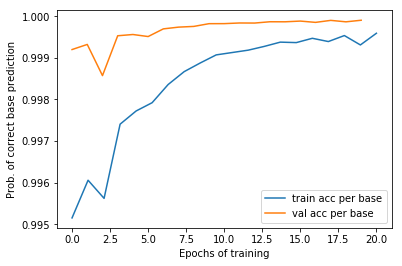

In [53]:
pred_errs_train_file = open('pred_errs_base_train.txt', 'r')

pred_errs_val_file = open('pred_errs_base_val.txt', 'r')

pred_errs_test_file = open('pred_errs_base_test.txt', 'r')

#pred_errs_train_file = open('pred_errs_seq_train.txt', 'r')
#pred_errs_val_file = open('pred_errs_seq_val.txt', 'r')
#pred_errs_test_file = open('pred_errs_seq_test.txt', 'r')

def format_str(s):
    s = s[1:(len(s)-1)]
    s = s.split(',')
    s = np.squeeze(s)
    #s = np.flip(s, axis = 0)
    s = np.delete(s, 0).astype(np.float)
    return(s)
    
train_err =  format_str(pred_errs_train_file.read())
#np.delete(np.flip(np.squeeze(pred_errs_train_file.read().split(',')), axis = 0), 0).astype(np.float)
val_err =  format_str(pred_errs_val_file.read())
test_err =  format_str(pred_errs_test_file.read())
pred_errs_train_file.close()
pred_errs_val_file.close()
pred_errs_test_file.close()

plt.plot(np.linspace(0,len(train_err), len(train_err)), 1-train_err, label="train acc per base")
plt.plot(range(len(val_err)), 1-val_err, label="val acc per base")
#plt.plot(range(len(test_err)), 1-test_err, label="test err per base")
plt.xlabel("Epochs of training")
plt.ylabel("Prob. of correct base prediction")

#plt.plot(self.x, self.val_losses, label="val_loss")
#plt.plot(self.x, self.val_acc, label = "val_acc")
plt.legend()
plt.show();
        

In [100]:
model.save("seqWeights/final/LSTM-2-model.h5")

In [77]:
model.load_weights("seqWeights/final/LSTM-2-comboseqs-dropout0.5-manytomany-19-0.89.hdf5")
errors = calcError(y_predicted = getPredicted(file, X_test[:, :, :]), 
                                        y_true = Y_test[:, :, :], X_data = X_test[:, :, :], verbose = True)


(12107, 308, 5)
(12107, 308, 5)
[251, 251, 251, 251, 251, 251, 251, 251, 251, 251]
Baseline error(num mismatched nucleotides between target and input average per sequence): 0.7288345585198646
Prediction error(num mismatched nucleotides between target and prediction average per sequence): 0.028826298835384487
Average good changes per sequence : 0.7060378293549187
Average bad changes per sequence: 0.0060295696704385894
Average failure to change per sequence: 0.0227967291649459


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


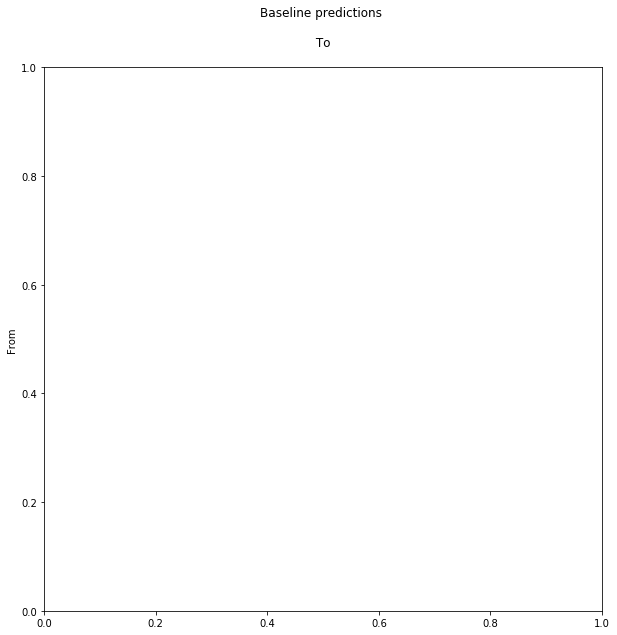

In [104]:
def plot_ind_conf(mat, type_pred, i):
    ax = fig.add_subplot(2, 2, i)
    cax = ax.matshow(mat)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + ['A', 'C','G', 'T', '-'])
    ax.set_yticklabels([''] + ['A', 'C','G', 'T', '-'])
    plt.ylabel("From")
    plt.title( type_pred + " predictions \n \n To \n")
    
def plot_conf(errors):
    fig = plt.figure(figsize = (10,10))  
    fig.subplots_adjust(hspace= 0.4, wspace=0.4)
    plot_ind_conf(errors['conf_mat']['good'], "Good", 1)
    plot_ind_conf(errors['conf_mat']['bad'], "Bad", 2)
    plot_ind_conf(errors['conf_mat']['fail'], "Fail To Change", 3)
    plot_ind_conf(errors['conf_mat']['baseline'], "Baseline", 4)
    
plot_conf(errors)

In [73]:
def calcError(y_predicted, y_true, X_data, verbose = False):
   #Returns # of noisy nucleotides when comparing the predicted seqs and the target seqs perBase or perSequence. Error perBase should be interpreted as the probability that any given base output by the model is incorrect. Error perSequence should be interpreted as the average number of incorrect output bases per sequence. So an error of .03 means there at .03 incorrect bases in every sequence. This translates to 3 incorrect bases every 100 sequences. 

    seq_lengths = [np.argmin(np.sum(X_data[i,:,:], axis = 1)) for i in range(X_data.shape[0])] #assumes 0000 for end of sequence. If there is no 0000, this will mess up, but I don't think that happens
    ind_to_char = np.array(['A', 'C','G', 'T', '-'])
    char_to_ind = {'A': 0, 'C': 1, 'G': 2, 'T': 3, '-': 4}
    if verbose:
        print(seq_lengths[0:10])
    baseline_error = 0
    pred_error = 0
    bad_changes = 0
    fail_to_change = 0
    good_changes = 0
    
    conf_mat = {}
    conf_mat['good'] = np.zeros((5, 5))
    conf_mat['bad'] = np.zeros((5, 5))
    conf_mat['fail'] = np.zeros((5, 5))
    conf_mat['baseline'] = np.zeros((5,5))
    
    for i in range(y_predicted.shape[0]):
        target_char = ind_to_char[np.argmax(y_true[i,0:seq_lengths[i]], axis = -1)]
        test_char = ind_to_char[np.argmax(X_data[i,0:seq_lengths[i]], axis = -1)]
        pred_char = ind_to_char[np.argmax(y_predicted[i,0:seq_lengths[i]], axis = -1)]

        baseline_error += np.sum(target_char != test_char) 
        pred_error += np.sum(target_char != pred_char) 

        to_red = np.where((target_char != pred_char) & (target_char == test_char))[0]
        to_green = np.where((target_char != test_char) & (target_char == pred_char))[0]
        to_blue = np.where((target_char != test_char) & (target_char != pred_char))[0]
        should_change = np.where((target_char != test_char))[0]
        
        for ind in to_green:
            ind1 = char_to_ind[test_char[ind]]
            ind2 = char_to_ind[pred_char[ind]]
            conf_mat['good'][ind1, ind2] += 1
        for ind in to_red:
            ind1 = char_to_ind[test_char[ind]]
            ind2 = char_to_ind[pred_char[ind]]
            conf_mat['bad'][ind1, ind2] += 1
        for ind in to_blue:
            ind1 = char_to_ind[test_char[ind]]
            ind2 = char_to_ind[target_char[ind]]
            conf_mat['fail'][ind1, ind2] += 1
        for ind in should_change:
            ind1 = char_to_ind[test_char[ind]]
            ind2 = char_to_ind[pred_char[ind]]
            conf_mat['baseline'][ind1, ind2] += 1

        bad_changes += len(to_red)
        good_changes += len(to_green)
        fail_to_change += len(to_blue)

        norm_seq = y_predicted.shape[0]
        norm_base = np.sum(seq_lengths)
    if verbose:
        print("Baseline error(num mismatched nucleotides between target and input average per sequence): " + str(baseline_error / norm_seq))
        print("Prediction error(num mismatched nucleotides between target and prediction average per sequence): " + str(pred_error / norm_seq))
        print( '\x1b[32m' + "Average good changes per sequence : " + '\x1b[0m'  + str(good_changes / norm_seq))
        print('\x1b[31m' + "Average bad changes per sequence: " + '\x1b[0m' + str(bad_changes / norm_seq))
        print('\x1b[34m' + "Average failure to change per sequence: "+ '\x1b[0m'  + str(fail_to_change / norm_seq)) 
    errors = {'conf_mat':conf_mat, 'perSeqErr': pred_error/norm_seq, 'perBaseErr': pred_error/norm_base}              
    
    return(errors)

In [79]:
def add_red(seq, to_red):
    if(len(to_red) == 0):
        return(''.join(seq))
    else:
        start = 0
        final_seq = ''
        for i in to_red:
            final_seq += ''.join(seq[start:i]) + '\x1b[31m' + str(seq[i]) + '\x1b[0m' 
            start = i + 1
        final_seq += ''.join(seq[start:len(seq)])
        return(final_seq)
    
def add_green(seq, to_green):
    if len(to_green) == 0:
        return(''.join(seq))
    else:
        start = 0
        final_seq = ''
        for i in to_green:
            final_seq += ''.join(seq[start:i]) + '\x1b[32m' + str(seq[i]) + '\x1b[0m' 
            start = i + 1
        final_seq += ''.join(seq[start:len(seq)])
        return(final_seq)
    
def add_blue(seq, to_blue):
    if len(to_blue) == 0:
        return(''.join(seq))
    else:
        start = 0
        final_seq = ''
        for i in to_blue:
            final_seq += ''.join(seq[start:i]) + '\x1b[34m' + str(seq[i]) + '\x1b[0m' 
            start = i + 1
        final_seq += ''.join(seq[start:len(seq)])
        return(final_seq)

In [88]:
#PRINT COLOR_CODED SEQUENCES
def printoutSeq(y_predicted, y_true, X_data, verbose = False):
    seq_lengths = [np.argmin(np.sum(X_data[i,:,:], axis = 1)) for i in range(X_data.shape[0])] #assumes 0000 for end of sequence. If there is no 0000, this will mess up, but I don't think that happens

    bad_changes = 0
    fail_to_change = 0
    good_changes = 0
    ind_to_char = np.array(['A', 'C','G', 'T', '-'])
    char_to_ind = {'A': 0, 'C': 1, 'G': 2, 'T': 3, '-': 4}
    numSeqs = 100
    for i in range(numSeqs):
        #each of these are character arrays
        target_char = ind_to_char[np.argmax(y_true[i,0:seq_lengths[i]], axis = -1)]
        test_char = ind_to_char[np.argmax(X_data[i,0:seq_lengths[i]], axis = -1)]
        pred_char = ind_to_char[np.argmax(y_predicted[i,0:seq_lengths[i]], axis = -1)]

        #subset if desired for visual appeal
        subset = 200
        target_char = target_char[100:subset]
        test_char = test_char[100:subset]
        pred_char = pred_char[100:subset]


        to_red = np.where((target_char != pred_char) & (target_char == test_char))[0]
        to_green = np.where((target_char != test_char) & (target_char == pred_char))[0]
        to_blue = np.where((target_char != test_char) & (target_char != pred_char))[0]

        bad_changes += len(to_red)
        good_changes += len(to_green)
        fail_to_change += len(to_blue)

        if(len(to_red) != 0 or len(to_green) != 0 or len(to_blue) != 0):
            print('Red: Should have stayed the same but didnt (bad)' + str(to_red))
            print('Green: Should have changed and did (good)' + str(to_green))
            print('Blue: Should have changed but didnt (ok)' + str(to_blue))


            print("T " + add_blue(add_green(add_red(target_char, to_red), to_green), to_blue))
            print("I " + add_blue(add_green(add_red(test_char, to_red), to_green), to_blue))
            print("P " + add_blue(add_green(add_red(pred_char, to_red), to_green), to_blue))
            print('\n')

    print("Average good changes per sequence : " + str(good_changes / numSeqs))
    print("Average bad changes per sequence: " + str(bad_changes / numSeqs))
    print("Average failure to change per sequence: " + str(fail_to_change / numSeqs))


#Summary: for the 10000 test examples, there were an average of 3.2 bases that needed to be changed per sequence (considered noise).
#Of these, the algorithm replaced 2.23 of them correctly, did not touch .97 of them, and replaced .01 of them incorrectly

#This means there is quite a bit of structure to learn!
    

In [89]:
printoutSeq(y_predicted = getPredicted(file, X_test[0:100, :, :]), 
                                        y_true = Y_test[0:100, :, :], X_data = X_test[0:100, :, :])

(100, 308, 5)
(100, 308, 5)
Red: Should have stayed the same but didnt (bad)[]
Green: Should have changed and did (good)[55]
Blue: Should have changed but didnt (ok)[]
T TTCCGATACTGTGAGTCTAGAGTCTCGAAGAGGAAGATGGAATTTCCGGTGTAACGGTGGAATGTGTAGATATCGGAAAGAACACCAGTGGCGAAGGCAG
I TTCCGATACTGTGAGTCTAGAGTCTCGAAGAGGAAGATGGAATTTCCGGTGTAACAGTGGAATGTGTAGATATCGGAAAGAACACCAGTGGCGAAGGCAG
P TTCCGATACTGTGAGTCTAGAGTCTCGAAGAGGAAGATGGAATTTCCGGTGTAACGGTGGAATGTGTAGATATCGGAAAGAACACCAGTGGCGAAGGCAG


Red: Should have stayed the same but didnt (bad)[]
Green: Should have changed and did (good)[ 1 12 16 19 22 36 38 71]
Blue: Should have changed but didnt (ok)[]
T CCTTGATACTGCACGA-CTCGAATCCGGGAGAGGGTGGCGGAATTCCAGGTGTAGGAGTGAAATCCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCG
I CTTTGATACTGC-CGAGCTAGAGTCCGGGAGAGGGTAGTGGAATTCCAGGTGTAGGAGTGAAATCCGTAGAGATCTGGAGGAACATCAGTGGCGAAGGCG
P CCTTGATACTGCACGA-CTCGAATCCGGGAGAGGGTGGCGGAATTCCAGGTGTAGGAGTGAAATCCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCG


Red: Should have stayed the same but didnt (bad)[

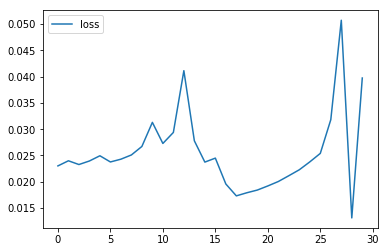

array([0.02300887, 0.0239837 , 0.02327125, 0.02394429, 0.02493877,
       0.0237598 , 0.02428735, 0.02509262, 0.02671051, 0.03129609,
       0.02728344, 0.02937831, 0.04113571, 0.02778651, 0.0237339 ,
       0.02448991, 0.01956574, 0.01730471, 0.01789672, 0.01841125,
       0.01919418, 0.02003692, 0.02114091, 0.02227397, 0.02377455,
       0.02539153, 0.0318067 , 0.05073694, 0.01310796, 0.03973856])

In [40]:
#Read in file to re-create training loss curve
file = open("log_loss.txt", 'r')
lines =  np.delete(np.flip(np.squeeze(file.read().split(',')), axis = 0), 0).astype(np.float)
plt.plot(range(len(lines)), lines, label="loss")
#plt.plot(self.x, self.val_losses, label="val_loss")
#plt.plot(self.x, self.val_acc, label = "val_acc")
plt.legend()
plt.show();
        
lines

In [ ]:
#numerical distance metrics - has problems with different length sequences!
matches_per_seq = np.sum(np.multiply(hard_max, target_seqs), axis = -1)
print(matches_per_seq.shape)
error_per_seq = np.mean(matches_per_seq, axis = 1)
print(error_per_seq.shape)
error = np.mean(error_per_seq)
print(error)
#On average, per example, we have a mismatch of 0.7 nucleotides between predicted and target output



In [ ]:
#baseline matrix multiplication
matches_per_seq = np.sum(np.multiply(test_input_seqs, target_seqs), axis = -1)
error_per_seq = np.mean(matches_per_seq, axis = 1)
error = np.mean(error_per_seq)
print(error)


#TODO
#convert back to character sequences and compare by eye
#Get actual sequence length per sequence




#print(np.sum(target != test))
#print(np.sum(target != pred))

In [ ]:
#translate and cal errors
indices = np.argmax(probs, axis = -1)
output_dict = np.array(['A', 'T', 'C', 'G', '-', '\t', '\n'])

error_baseline_sum = 0
error_output_sum = 0
#input_seqs = diff_entries_input + same_entries_input[1:50000]
#output_seqs = diff_entries_output + same_entries_output[1:50000]

for i in range(indices.shape[0]):
    pred = ''.join(output_dict[indices[i,]])
    inp = input_seqs[i]
    out = output_seqs[i]
    print("predicted: " + pred)
    print("Input: " + inp)
    print("Output: " + out)
    print('\n')
    
    error_baseline = np.sum([1  for j in range(len(inp)) if inp[j] != out[j] ])
    error_output = np.sum([1  for j in range(len(inp)) if pred[j] != out[j] ])
    error_baseline_sum += error_baseline
    error_output_sum += error_output
                          
    #print("Pred - Input: " +  str(np.sum([1  for i in range(len(inp)) if pred[i] != inp[i] ] )))
    #print("Pred - Output (ie We care): " +  str(error_output ))
    #print("Input - Output (ie Baseline): " +  str(error_baseline ))
    
print("Baseline error (average noisy nucleotide per sequence): " + str(error_baseline_sum / indices.shape[0]))
print("Output error (average noisy nucleotide per sequence): " + str(error_output_sum / indices.shape[0]))
      

In [ ]:
#save history and continue training
with open("seqWeights/LSTM-manytomany.txt", 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
model.load_weights("seqWeights/LSTM-manytomany-17-0.87.hdf5")
adam = keras.optimizers.Adam(lr = .001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])
model.fit(encoder_input_data[0:numExamples, :, :],
          decoder_input_data[0:numExamples, :, :],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2, verbose = 1,
         callbacks = [history, checkpoint])

In [ ]:
batch_size = 50
epochs = 50
numExamples = 10000


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#model.load_weights("seqWeights/LSTM7layer-05-0.82.hdf5")
adam = keras.optimizers.Adam(lr = .01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])

# Run training
history = History()
filepath="LSTM7layer-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


model.fit([encoder_input_data[0:numExamples, :, :], decoder_input_data[0:numExamples, :, :]], decoder_target_data[0:numExamples, :, :],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2, verbose = 1,
          callbacks = [history, checkpoint])


In [ ]:
model.load_weights("seqWeights/LSTM-manytomany-17-0.87.hdf5")

In [ ]:
encoder_model_inf = Model(encoder_inputs, [e_h1, e_c1, e_h2, e_c2, e_h3, e_c3, e_h4, e_c4])

In [ ]:
#Inference on new sequence

d_input_states = [d_input_h1, d_input_c1, d_input_h2, d_input_c2, d_input_h3, d_input_c3, d_input_h4, d_input_c4]
d_input_h1 = Input(shape = (latent_dim, ))
d_input_c1 = Input(shape = (latent_dim, ))
d_input_h2 = Input(shape = (latent_dim, ))
d_input_c2 = Input(shape = (latent_dim, ))
d_input_h3 = Input(shape = (latent_dim, ))
d_input_c3 = Input(shape = (latent_dim, ))
d_input_h4 = Input(shape = (latent_dim, ))
d_input_c4 = Input(shape = (latent_dim, ))


d_out_1, d_h1, d_c1 = d_lstm_1(decoder_inputs, initial_state = [d_input_h1, d_input_c1])
d_out_2, d_h2, d_c2 = d_lstm_2(d_out_1, initial_state = [d_input_h2, d_input_c2])
d_out_3, d_h3, d_c3 = d_lstm_3(d_out_2, initial_state = [d_input_h3, d_input_c3])
d_out_4, d_h4, d_c4 = d_lstm_4(d_out_3, initial_state = [d_input_h4, d_input_c4])

d_output_states = [d_h1, d_c1, d_h2, d_c2, d_h3, d_c3, d_h4, d_c4 ]

decoder_out = d_dense(d_out_4)
decoder_model_inf = Model(inputs = [decoder_inputs] + [d_input_h1, d_input_c1, d_input_h2, d_input_c2, d_input_h3, d_input_c3, d_input_h4, d_input_c4],
                         outputs = [decoder_out] + [d_h1, d_c1, d_h2, d_c2, d_h3, d_c3, d_h4, d_c4 ])

In [ ]:
index_to_nuc = ['A', 'T', 'C', 'G', '-', '\t', '\n']
def decode_seq(inp_seq):
    print(inp_seq.shape)
    states = encoder_model_inf.predict(inp_seq)
    print(len(states))
    target_seq = np.zeros((1,1,num_decoder_tokens))
    target_seq[0,0, one_hot_input['\t']] = 1
    
    translated_seq = ''
    stop_condition = False
    
    while not stop_condition:
        decoder_out, d_h1, d_c1, d_h2, d_c2, d_h3, d_c3, d_h4, d_c4  = decoder_model_inf.predict(x = [target_seq] + states)
        
        max_val_index = np.argmax(decoder_out[0, -1, :])
        sampled_nucleotide = index_to_nuc[max_val_index]
        translated_seq += sampled_nucleotide
        
        if (sampled_nucleotide == '\n'):
            stop_condition = True
        
        target_seq = np.zeros((1,1, num_decoder_tokens))
        target_seq[0,0, max_val_index] = 1
        
        states = [d_h1, d_c1, d_h2, d_c2, d_h3, d_c3, d_h4, d_c4]
    return(translated_seq)

In [ ]:
input_seqs = diff_entries_input
output_seqs = diff_entries_output

for i in range(10):
    input_seq = np.array(np.expand_dims(encoder_input_data[i, :, :], axis = 0))
    trans_seq = decode_seq(input_seq)
    print("Original Sequence: " + input_seqs[i])
    print("Predicted Sequence: " + trans_seq)
    print("Target Sequence: " + output_seqs[i])
    
#Metric can be standard confusion matrix: of the bases that should have been substituted, how many were substituted correctly (true positive)
#of the bases that should not have been substituted, how many were not substituted, true negative
# of the bases that should not have been substituted, how many were: false positive
# of the bases that should have been substituted, how many were not: false negative.

In [ ]:
#pickle.load(open( "history_lr0.001", "rb" ) )

In [ ]:
lr = 0.01
history = pickle.load(open('history_lr' + str(lr), "rb"))
def plot_loss(history):
    epochs = len(history["loss"])
    plt.plot(range(0, epochs), history["loss"])
    plt.plot(range(0, epochs), history["val_loss"])
plot_loss(history)

In [ ]:
history_new = History()

In [ ]:
def continue_train_model(model, history, model_save, history_save, lr = .01, epochs = 10, batch_size = 50):
    
    history_new = History()
    
    adam = keras.optimizers.Adam(lr = lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])
    model.fit([encoder_input_data[0:numExamples, :, :], 
               decoder_input_data[0:numExamples, :, :]],
               decoder_target_data[0:numExamples, :, :],
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.2, 
                verbose = 1,
                callbacks = [history_new])

    #update history
    for k in history.keys():
        history[k] = history[k] + history_new.history[k]
    with open(history_save, 'wb') as file_pi:
        pickle.dump(history, file_pi)
        
    #Save model
    model.save(model_save)
    return(model, history)

In [ ]:
#Load and continue training as desired
lr = 0.001
model = load_model('s2s_lr.01_lr.001.h5')
history = pickle.load(open('history_lr.01_ly.001.h5', "rb"))

model, history = continue_train_model(model = model, history = history, model_save = ('s2s_lr.01_lr.001.h5'), history_save = ('history_lr.01_ly.001.h5'), 
                                      lr = .001, epochs = 10, batch_size = 50)
 
    
plot_loss(history)

In [ ]:
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

In [ ]:
def define_model_multilayer(num_encoder_tokens, num_decoder_tokens):
    model = Sequential()
    model.add(Embedding(input_dim = num_encoder_tokens, output_dim=162))
    model.add(LSTM(units = 100, return_sequences=True, input_shape = (None, 162))) #None refers to unknown sequence length
    model.add(LSTM(100, return_sequences = True))
    model.add(LSTM(50, return_sequences = True))
    model.add(Dense(162, activation = "softmax"))
    adam = keras.optimizers.Adam(lr = .01, beta_1=0.9, beta_2 = 0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])
    
    return(model)
              

In [ ]:

#With more latent dimensions
numExamples = 5000
batch_size = 50
epochs = 2

model = define_model_multilayer(num_encoder_tokens = 7, num_decoder_tokens = 7)
history = History()

print(len(diff_entries_input[0]))
print(encoder_input_data[1, 1, :])
print(encoder_input_data[0:numExamples, :, :].shape)
#model.fit(encoder_input_data[0:numExamples, :, :],
#          decoder_target_data[0:numExamples, :, :],
#          batch_size=batch_size,
#          epochs=epochs,
#          validation_split=0.1, 
#          verbose = 1,
#          callbacks = [history])

model.fit(np.array(diff_entries_input)[0:numExamples, ],
          np.array(diff_entries_output)[0:numExamples, ],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1, 
          verbose = 1,
          callbacks = [history])

In [ ]:
probs = model.predict(encoder_input_data[0:5, :, :])
print(len(probs))
probs = np.array(probs)
print(probs.shape)
indices = np.argmax(probs, axis = -1)

output_dict = np.array(['A', 'T', 'C', 'G', '-', '\t', '\n'])
for i in range(indices.shape[0]):
    print(output_dict[indices[i,]])
    
